# Policy Gradient in Reinforcement Learning

As we saw in the [previous tutorials](./01-dqn.ipynb), Q-Learning is a baseline method for optimizing generic RL problems, but there exist a lot of problems in stochastic environments - such as, cannot handle the continuous space, empirical greedy exploration, so on and so forth.

In order to overcome, the stochastic distributions are introduced in recent algorithms.

> Note : Applying continuous actions is still challenging in RL. See [this example](https://tsmatz.wordpress.com/2021/11/11/reinforcement-learning-visual-attention-in-minecraft/) for applying continuous action in video game.

As you saw in previous exercise, the next action is deterministically picked up based on a Q-table or Q-function. That is, the policy is **deterministic**.<br>
On contrary, the next action in this example will be picked up based on a **stochastic** space (i.e, non-deterministic). As you'll see in this tutorial, the policy is then trained to pick up the input for a stochastic distribution (which determines a stochastic space), not picking up the next action itself.

For instance, you will be able to use categorical distribution for discrete action spaces, Gaussian distribution for ```Box``` (i.e, continuos) action spaces, and Beta distribution for the bounded ```Box``` action spaces.<br>

By introducing stochastic spaces, you don't also need to apply empirical greedy exploration any more.

Today, there exist a lot of advanced on-policy algorithms, but firstly this tutorial shows you the primitive idea of on-policy learning using simple program code.

> Note : Here I'll show you vanilla (plain) policy gradient architecture for the purpose of your beginning, but most algorithms with policy gradient involves advanced other tricks in practice. (See [Actor-Critic](./03-actor-critic.ipynb) or [PPO](./04-ppo.ipynb) examples.)

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [3]:
# !pip install torch numpy gymnasium matplotlib

In [4]:
# import gymnasium as gym
import gym
import numpy as np
import torch, random
import torch.nn as nn
from torch.nn import functional as F

random.seed(20)
np.random.seed(20)
torch.manual_seed(20)

In policy gradient, the action $a$ is picked up by the distribution $P$ which depends on policy $\pi$.<br>
To say more clearly, the distibution of action is represented by $ P(a | \pi_\theta (s)) $, where $ \pi_\theta (s) $ is policy and $\theta$ is parameters for this policy. When the current state $s$ is given, the distribution of action $a$ (such as, in categorical distribution, Gaussian distribution, etc) is determined by this policy $\pi$.

In this CartPole example, we assume that $P(\cdot)$ is a categorical distribution (because action space is discrete) and $\pi_\theta (s)$ is a fully-connected network (fcnet) which has 2 outputs.<br>
In this example, the outputs of this policy $\pi_\theta (s)$ are logits value (see the following note for logits), which determines categorical distribution $P(\cdot)$.

![policy](assets/policy.png)

> Note : When logits $l_0, l_1$ are given, the probabilities are $\frac{e^{l_0}}{e^{l_0}+e^{l_1}}, \frac{e^{l_1}}{e^{l_0}+e^{l_1}}$ respectively in categorical distribution.

Now, we implement $\pi_\theta (s)$ (fully-connected network) using PyTorch as follows.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyPi(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.classify = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.classify(outs)
        return logits

policy_pi = PolicyPi(128).to(device)

In each episode, we consider the following expectation $E_{\pi_\theta}[R]$.
$$ E_{\pi_\theta}[R]=\int_a{R(a) \cdot P(a|\pi_\theta(s))} $$
where $R$ is the cumulative expected rewards $ R = \sum{\gamma r} $, and $\gamma$ is discount rate. (See [Q-Learning](./00-q-learning.ipynb) for $ \sum{\gamma r} $.)

> Note : To simplify, here I have used $ \int_a R P $, but consider $ \int_{\tau} R P $ for any trajectory $ \tau $.

To get the optimimal $ \theta $ which maximizes $E$, we apply the gradient descent $ \theta_{t+1} \leftarrow \theta_t + \Delta \theta $<br>
where
$$ \Delta \theta = \alpha R \cdot \nabla_{\theta} \log{P(a|\pi_\theta(s))} \;\;\;\;\; (1) $$
and $\alpha$ is learning rate.

<blockquote>
Note : Here I don't go so far, but this formula is derived from the following equation. It's difficult to know $ \nabla E $ directly, but this formula can be easily used on each step in gradient algorithms.

$$ \nabla_{\theta} \int{R(a) \cdot P(a|\pi_\theta(s))} = \int{R(a) \nabla_{\theta}{\log P(a|\pi_\theta(s))} \cdot P(a|\pi_\theta(s))} $$
</blockquote>

As you can see in the equation (1), if the expected reward $R$ is positively large, the probability to take action $a$ in the state $s$ will be increased by modifying $\theta$. On contrary, if the expected reward $R$ is negative, $\theta$ will be changed to decrease the probability to take this action $a$.

As you find, this algorithm will improve a stochastic policy by updating action's policy $ P( \cdot | \pi_\theta (s)) $, not only depending on empirical greedy action sampling such as used in [Q-learning](./00-q-learning.ipynb) and [DQN](./01-dqn.ipynb). This method is then called **on-policy** learning.<br>
(In "[DDPG](./05-ddpg.ipynb)", I'll introduce another approach to operate continuos action by off-policy way.)

To implement this optimization, the training script will become as follows.

I note that cross-entropy error is equivalent to the negative value of log probability ($ -\log P$) in categorical distribution. So I have used ```torch.nn.functional.cross_entropy()``` instead of directly computing log probability in the following code.

In [8]:
gamma = 0.99
epoch = 800

# Pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = policy_pi(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make("CartPole-v0")
# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

reward_records = []

opt = torch.optim.AdamW(policy_pi.parameters(), lr=0.001)
for i in range(epoch):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    s = env.reset()
    count = 0
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        
        # Compute custom rewards
        # Extract state variables
        x = abs(s[0])  # Cart position (absolute value)
        theta = abs(s[2])  # Pole angle (absolute value)
        
        weight1=0.15
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward
        
        done = term or trunc
        actions.append(a)
        #rewards.append(r)
        count+=1
        rewards.append(reward)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    opt.zero_grad()
    logits = policy_pi(states)
    # Calculate negative log probability (-log P) as loss.
    # Cross-entropy loss is -log P in categorical distribution. (see above)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    loss = -log_probs * cum_rewards
    loss.sum().backward()
    opt.step()

    # reward_records.append(sum(rewards))
    reward_records.append(count)
    
    # Record total rewards in episode (max 500 for v1 and 200 for v0)
    # print("Run episode{} with rewards {}".format(i, sum(rewards)), end="\r")
    print("Run episode{} with rewards {}".format(i, count), end="\r")
    
    # stop if reward mean > 495.0
    if np.average(reward_records[-100:]) >= 195.0:
        break

print("\nDone")
env.close()

Run episode365 with rewards 200
Done


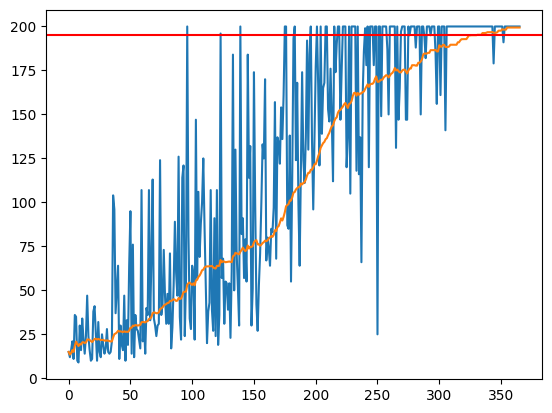

In [9]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
plt.plot(reward_records)
plt.plot(average_reward)

plt.axhline(y=195, color='r', linestyle='-')
plt.show()

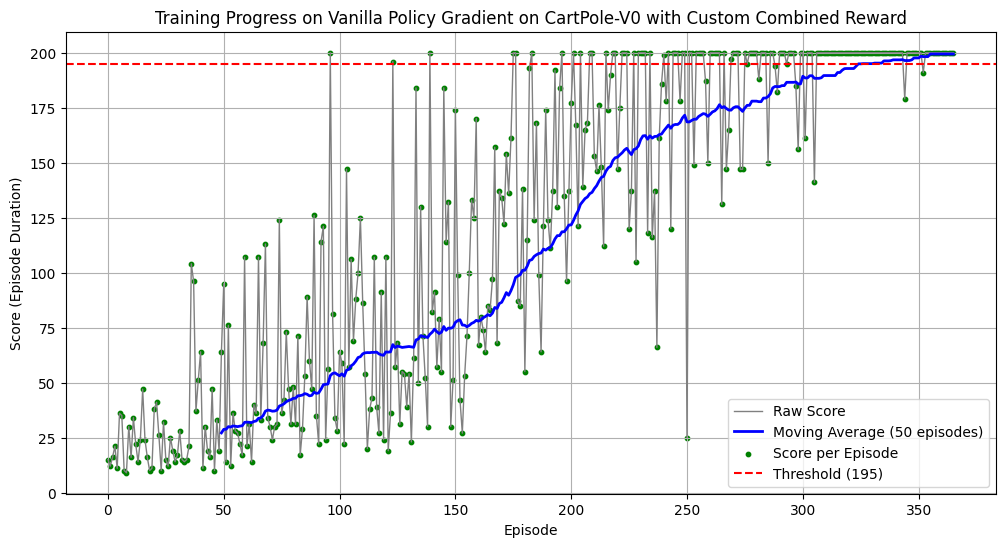

In [10]:
# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):
    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    # plt.title('Training Progress of %s on CartPole with Custom Combined Reward'%(name))
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_train('Vanilla Policy Gradient on CartPole-V0', reward_records, 50)

Today the vanilla policy gradient (discussed here) will not be used in practice, and this example is then only for experimental purpose.<br>
In the [next example](./03-actor-critic.ipynb), we will improve this example for stable convergence.

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 182.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 173.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 162.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 135.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
count    100.000000
mean     198.520000
std        8.104719
min      135.000000
25%      200.000000
50%      200.000000
75%      200.000000
max      200.000000
Name: score, dtype: float64
success
True     96
False     4
Name: count, dtype: int64


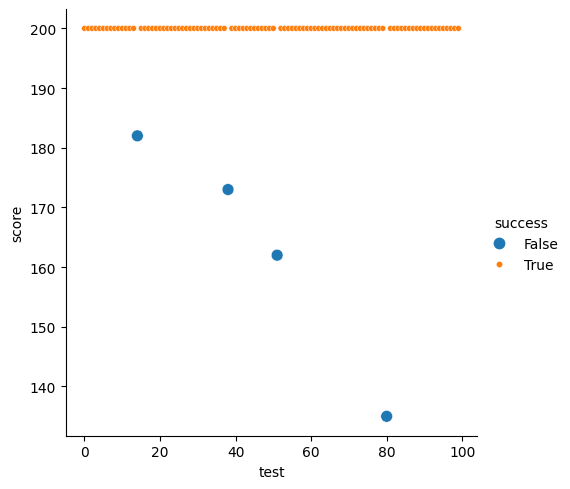

In [12]:
import pandas as pd
import seaborn as sns

def test_agent(i, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(i)
    s = env.reset()
    env.seed(i)
    rewards = []
    obs=[]
    for t in range(200):
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        done = term or trunc
        rewards.append(r)
        #print(sum(rewards))  
        if done:
            rew = sum(rewards)
            if print_reward:
                print("Reward:", rew)
            return rew
    env.close()


def plot_test_results(total=100):
    test_scores = []
    for i in range(total):
        test_scores.append(test_agent(i, print_reward=False))
        
    print(test_scores)

    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>195)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    sns.relplot(data=test_df, x="test", y="score", hue="success", size="success")
    plt.show()
    
plot_test_results(total=100)